In [1]:
# imports
import pandas as pd
import numpy as np
from pdpbox import pdp, info_plots
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
import category_encoders as ce

In [2]:
# load in the dataset -- change filepath as appropriate
df = pd.read_csv(r"../data/restaurants.csv")

In [3]:
# let's fill in our missing values for now
df = df.fillna(0)

# sort values
df.sort_values(by=['id', 'visit_date'], ascending=True, inplace=True)
# we'll create this column for display purposes
df['city'] = df['area'].str.split('-').str[0]
# create training & test sets
train = df.groupby('id').apply(lambda x: x.iloc[:-15])
test  = df.groupby('id').apply(lambda x: x.iloc[-15:])

# and do our splits
X_train, y_train = train.drop(['visit_date', 'visitors'], axis=1), train['visitors']
X_test, y_test   = test.drop(['visit_date', 'visitors'], axis=1), test['visitors']

In [4]:
# setup our model -- using the onehot encoder -- makes these things a *little* easier to rende
pipe = make_pipeline(ce.TargetEncoder(), GradientBoostingRegressor())
# and fit
pipe.fit(X_train, y_train)

Pipeline(steps=[('targetencoder',
                 TargetEncoder(cols=['id', 'calendar_date', 'day_of_week',
                                     'genre', 'area', 'city'])),
                ('gradientboostingregressor', GradientBoostingRegressor())])

In [21]:
pipe[1].get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [17]:
pipe[0]

TargetEncoder(cols=['id', 'calendar_date', 'day_of_week', 'genre', 'area',
                    'city'])

In [20]:
pipe[0].transform(X_train)

id  calendar_date  day_of_week  holiday  \
id                                                                            
air_00a91d42b08b08d9 166836  25.889401      24.552180    23.021194        0   
                     166837  25.889401      26.474898    26.250407        0   
                     166838  25.889401      16.762440    17.240350        0   
                     166839  25.889401      17.473684    17.720715        0   
                     166840  25.889401      19.309524    19.231336        0   
...                                ...            ...          ...      ...   
air_fff68b929994bfbd 216629   5.137795      18.385666    17.240350        0   
                     216630   5.137795      18.991830    17.720715        0   
                     216631   5.137795      20.379310    19.231336        0   
                     216632   5.137795      17.903846    18.929925        0   
                     216633   5.137795      24.192913    23.021194        0   

                                 genre       area   latitude   longitude  \
id                                                                         
air_00a91d42b08b08d9 166836  22.553878  26.268049  35.694003  139.753595   
                     166837  22.553878  26.268049  35.694003  139.753595   
                     166838  22.553878  26.268049  35.694003  139.753595   
                     166839  22.553878  26.268049  35.694003  139.753595   
                     166840  22.553878  26.268049  35.694003  139.753595   
...                                ...        ...        ...         ...   
air_fff68b929994bfbd 216629  13.298205  15.905319  35.708146  139.666288   
                     216630  13.298205  15.905319  35.708146  139.666288   
                     216631  13.298205  15.905319  35.708146  139.666288   
                     216632  13.298205  15.905319  35.708146  139.666288   
                     216633  13.298205  15.905319  35.708146  139.666288   

                             reserve_visitors      city  
id                                                       
air_00a91d42b08b08d9 166836               0.0  20.43029  
                     166837               4.0  20.43029  
                     166838               0.0  20.43029  
                     166839               0.0  20.43029  
                     166840               0.0  20.43029  
...                                       ...       ...  
air_fff68b929994bfbd 216629               0.0  20.43029  
                     216630               0.0  20.43029  
                     216631               2.0  20.43029  
                     216632               8.0  20.43029  
                     216633               1.0  20.43029  

[239673 rows x 10 columns]

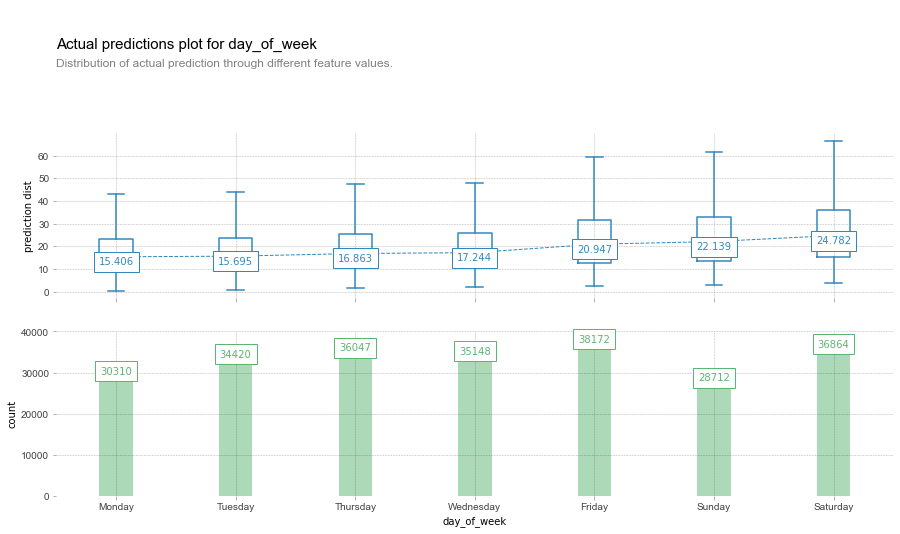

In [19]:
# this chart summarizes the model predictions made for each unique value in the day_of_week column
fig, axes, summary_df = info_plots.actual_plot(
    # notice these options -- accesing the appropriate parts of our pipeline to get the data setup
    # For X we are passing in what our model will use to predict; which is why we need to transform X_train
    model=pipe[1], X=pipe[0].transform(X_train), 
    feature='day_of_week', feature_name='day_of_week', predict_kwds={}
)

# this is just to get the tick marks to render correctly on the bottom
_ = axes['bar_ax'].set_xticklabels(['Monday', 'Tuesday', 'Thursday', 'Wednesday', 'Friday', 'Sunday', 'Saturday'])

In [8]:
# chart is being created from this variable
summary_df

,x,display_column,value_lower,value_upper,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,"[17.24, 17.72)",17.240350,17.720715,30310,9.944070,15.405807,23.151905
1,1,"[17.72, 18.93)",17.720715,18.929925,34420,10.146473,15.694589,23.727074
2,2,"[18.93, 19.23)",18.929925,19.231336,36047,10.767093,16.863035,25.508698
3,3,"[19.23, 23.02)",19.231336,23.021194,35148,10.893821,17.244491,25.828754
4,4,"[23.02, 23.84)",23.021194,23.842540,38172,12.704664,20.947307,31.528156
5,5,"[23.84, 26.25)",23.842540,26.250407,28712,13.485590,22.139427,32.758578
6,6,"[26.25, 26.25]",26.250407,26.250407,36864,15.303116,24.782447,35.851189


Now, let's build our actual PARTIAL DEPENDENCE PLOT.

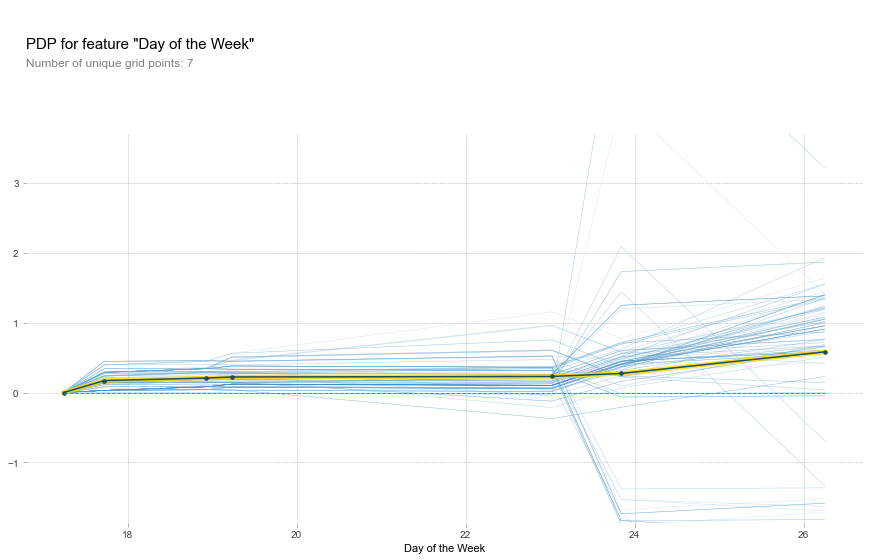

In [22]:
# what was the additive impact of EACH unique value of OverallQual?  What was its marginal impact?
pdp_day_of_week = pdp.pdp_isolate(
    model=pipe[1], dataset=pipe[0].transform(X_train), model_features=X_train.columns.tolist(), 
    feature='day_of_week', cust_grid_points = pipe[0].transform(X_train)['day_of_week'].tolist()
)
# cust_grid_points will bin values together by default / or could bin into specific groups.

fig, axes = pdp.pdp_plot(pdp_day_of_week, 'Day of the Week', plot_lines=True, frac_to_plot=100)

* Above gives a sense of how each observation impacts the overall numbers. Which is nice so we understand what is going on.
* i.e. in this cae we see certain restaurants look like they close (i.e. less visitors) on the weekend

In [25]:
pdp_day_of_week.pdp

array([20.68056855, 20.85170951, 20.88824186, 20.90307284, 20.91059647,
       20.95344565, 21.26220744])

In [26]:
np.diff(pdp_day_of_week.pdp) # Looks at how average line above is generated

array([0.17114096, 0.03653235, 0.01483097, 0.00752364, 0.04284918,
       0.30876179])

In [9]:
pdp_day_of_week.ice_lines


,17.240350,17.720715,18.929925,19.231336,23.021194,23.842540,26.250407
0,30.497139,30.786459,30.838689,30.830768,30.812991,28.617129,28.455380
1,32.942999,33.232319,33.284549,33.276628,33.258851,31.062989,30.901240
2,21.324602,21.613922,21.666152,21.658231,21.640454,19.444592,19.282843
3,22.182696,22.472016,22.524246,22.516325,22.498548,20.302686,20.140937
4,24.109705,24.399025,24.451255,24.443334,24.425557,22.229696,22.067946
...,...,...,...,...,...,...,...
239668,4.642931,4.861178,4.871128,4.871128,4.601600,4.884124,5.322812
239669,4.572276,4.790523,4.800473,4.800473,4.530946,4.813469,5.252157
239670,5.239603,5.457851,5.467800,5.467800,5.198273,5.480797,5.919484
239671,4.545054,4.763302,4.773251,4.773251,4.503724,4.786248,5.224935


### PDP for OneHot Encoded Columns

Lots of times your categorical data will be one hot encoded.  PDP plots render a bit more naturally if your data is setup this way, so it's a good idea to keep this in mind if you want to run these plots.  Let's setup our model to one hot encode the `genre` column and see how we can get these values to render.

In [27]:
# create a new pipeline -- this time onehot encoding the genre column
pipe = make_pipeline(ce.OneHotEncoder(cols=['city'], use_cat_names=True), ce.TargetEncoder(), GradientBoostingRegressor())
# fit our model again
pipe.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['city'], use_cat_names=True)),
                ('targetencoder',
                 TargetEncoder(cols=['id', 'calendar_date', 'day_of_week',
                                     'genre', 'area'])),
                ('gradientboostingregressor', GradientBoostingRegressor())])

In [33]:
pipe[0]

OneHotEncoder(cols=['city'], use_cat_names=True)

In [34]:
pipe[1]

TargetEncoder(cols=['id', 'calendar_date', 'day_of_week', 'genre', 'area'])

In [35]:
pipe[2]http://localhost:8888/notebooks/OneDrive/General-Assembly/my-1019-repo/ClassMaterial/Unit3/Class15/Partial%20Dependence%20Plotting%20--%20Restaurants%20Dataset%20-%20Continued.ipynb#

GradientBoostingRegressor()

In [30]:
 pipe[0].get_feature_names()

['id',
 'calendar_date',
 'day_of_week',
 'holiday',
 'genre',
 'area',
 'latitude',
 'longitude',
 'reserve_visitors',
 'city_Tōkyō',
 'city_Ōsaka',
 'city_Hyōgo',
 'city_Hiroshima',
 'city_Fukuoka',
 'city_Hokkaidō Sapporo',
 'city_Miyagi',
 'city_Niigata',
 'city_Hokkaidō Asahikawa',
 'city_Hokkaidō Abashiri',
 'city_Shizuoka',
 'city_Hokkaidō Katō']

In [28]:
# first, let's grab the columns with genre in them
city_cols = [col for col in pipe[0].get_feature_names() if 'city' in col]
city_cols

['city_Tōkyō',
 'city_Ōsaka',
 'city_Hyōgo',
 'city_Hiroshima',
 'city_Fukuoka',
 'city_Hokkaidō Sapporo',
 'city_Miyagi',
 'city_Niigata',
 'city_Hokkaidō Asahikawa',
 'city_Hokkaidō Abashiri',
 'city_Shizuoka',
 'city_Hokkaidō Katō']

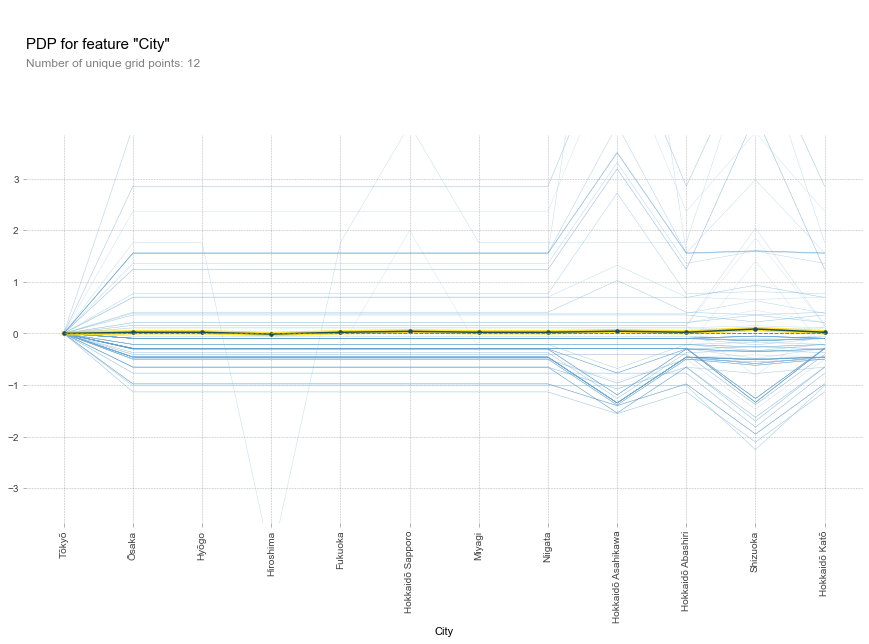

In [36]:
# and what about categorical variables?
# what was the impact of genre on attendance?
pdp_city = pdp.pdp_isolate(
    model=pipe[2], 
    # dataset -- create the final transformation of our data
    dataset=pipe[1].transform(pipe[0].transform(X_train)), 
    # All features in the model
    model_features=pipe[1].get_feature_names(), 
    # this is the list of all the columns for the genre feature
    feature=city_cols
)

fig, axes = pdp.pdp_plot(pdp_city, 'City', plot_lines=True, frac_to_plot=100)
# this code is just for formatting -- getting the labels to format correctly
xtick_labels = [city.split('_')[1] for city in city_cols]
axes['pdp_ax'].set_xticklabels(xtick_labels, rotation='vertical');

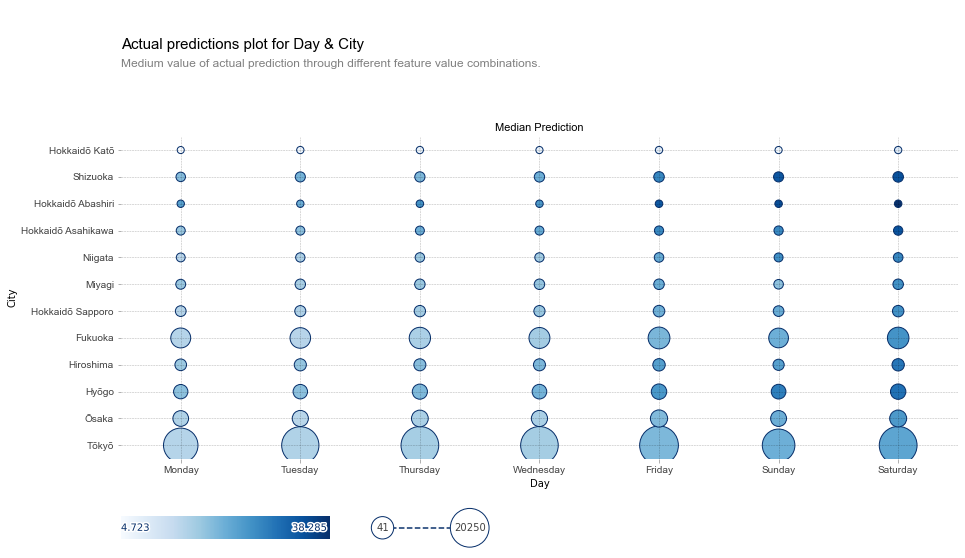

In [13]:
# and what about interactions?
# Since we have a longer pipeline, we use the GBM from pipe[2]
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=pipe[2], X=pipe[1].transform(pipe[0].transform(X_train)), 
    features=['day_of_week', city_cols], 
    feature_names=['Day', 'City']
)

axes['value_ax'].set_yticklabels(xtick_labels);
axes['value_ax'].set_xticklabels(['Monday', 'Tuesday', 'Thursday', 'Wednesday', 'Friday', 'Sunday', 'Saturday']);

The above compares the interaction between two columns.
Size of circles show number of predictive values that fall in each bucket.
Colour relates to average predicted value that was produced.

Slighly different version of the boxplot chart above.


***
## How do changes between columns influence each other
**This section is probably the most useful aspect of this library**

* This involves adjusting two columns in turn but at two columns at once.

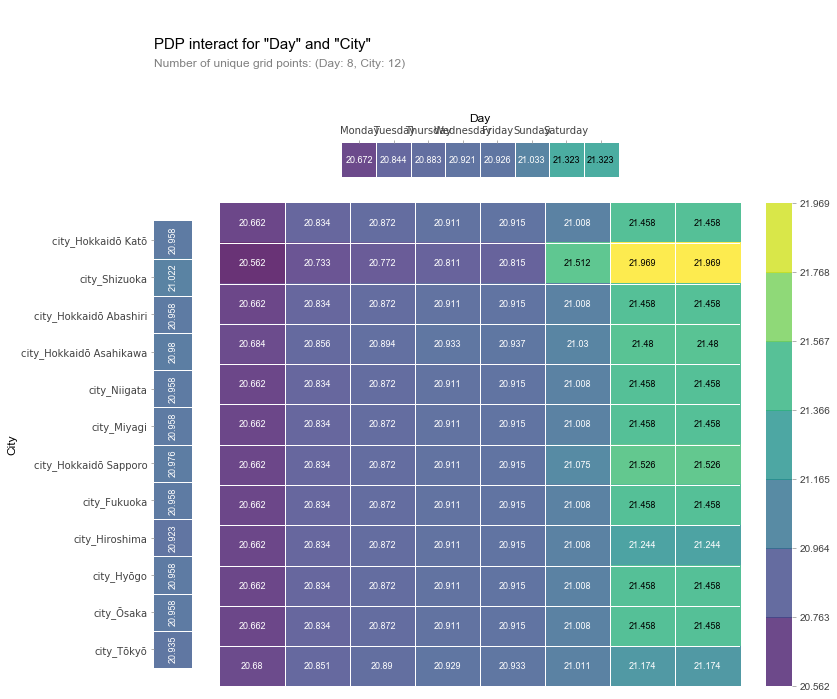

In [143]:
# and a slightly different look at the same problem
gbm_inter = pdp.pdp_interact(
    model=pipe[2], dataset=pipe[1].transform(pipe[0].transform(X_train)), model_features=pipe[1].get_feature_names(), 
    features=['day_of_week', city_cols]
)


fig, axes = pdp.pdp_interact_plot(
    gbm_inter, ['Day', 'City'], x_quantile=True, plot_type='grid', plot_pdp=True
)
axes['pdp_inter_ax']['_pdp_inter_ax'].set_xticklabels(['Monday', 'Tuesday', 'Thursday', 'Wednesday', 'Friday', 'Sunday', 'Saturday'], rotation='vertical');

In [37]:
# this is the dataset used to generate the above plot
gbm_inter.pdp

NameError: name 'gbm_inter' is not defined